In [16]:
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
# import visualkeras

import datetime
import ephem

import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import pypalettes 
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import json
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfea
import pyproj
import imageio.v2 as imageio
from io import BytesIO
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import custom_functions as cf
import custom_for_model as cfm
import custom_generator_2_0 as cgen
import custom_losses as cl


palette = "Prism"
# cmap = pypalettes.load_cmap(palette, type="continuous", keep=[True, True, True, True, True, True, True])
palette_hex_list = pypalettes.get_hex(palette)
cmap_name = 'cmap_sealevel'
cmap_hex_list = [palette_hex_list[5],palette_hex_list[6],palette_hex_list[2],palette_hex_list[1],palette_hex_list[0]]
rgb_colors = [mcolors.hex2color(color) for color in cmap_hex_list]
cmap = LinearSegmentedColormap.from_list(cmap_name, rgb_colors, N=256)

cmap_name = 'cmap_generator_batch_plots'
rgb_colors = [mcolors.hex2color(color) for color in palette_hex_list[::-1]]
cmap_gen_plot = LinearSegmentedColormap.from_list(cmap_name, rgb_colors, N=256)

# Load settings
with open('settings.json', 'r') as file:
    settings = json.load(file)

2.16.1


In [17]:
data_path= settings["data_path"]
output_path=settings["output_path"]
img_path=settings["img_path"]
local_data_path= os.getcwd()+'/Data/'

lat = settings["lat"]
lon = settings["lon"]

## Data Parser-Generator for loading data

## __________________________________________________________________________________________________________


In [18]:
directories = {
    'ERA5': data_path+'ERA5/u_v_t_mslp/',  # Directory .grib
    'solar_lunar': output_path+'surrogate_GTSM_model/moon_and_sun_lat_'+str(lat)+'_lon_'+str(lon)+'/', # Directory .txt
    'mean_sea_level': output_path+'surrogate_GTSM_model/hourly_reanalisis_msl_lat_'+str(lat)+'_lon_'+str(lon)+'/', # Directory .txt
    "surge_and_waterlevel": data_path+'GTSM/reanalysis_era5_waterlevel_surge_hourly/' # Directory .nc
}

with open(local_data_path+'nearest_station_index_lat_'+str(lat)+'_lon_'+str(lon)+'.json', 'r') as json_file:
    nearest_station_index = json.load(json_file)
    nearest_station_index = nearest_station_index['nearest_station_index']

n_files=1

variable=["u10","v10","t2m","msl"]
train_files_shuffle = bool(settings["train_files_shuffle"])
train_y_bounds = settings["train_y_bounds"]
train_month_start_end = settings["train_month_start_end"]
lat_bounds = settings["lat_bounds"]
lon_bounds = settings["lon_bounds"]
LSTM_recurrent_steps = settings["LSTM_recurrent_steps"]
ms_recurrent_steps = settings["ms_recurrent_steps"]
output_type = bool(settings["output_type"])
preprocess = settings["preprocess"]
kfold = bool(settings["kfold"])
folds_number = settings["folds_number"]
loss_type = settings["loss_type"]

model_type = settings["model_type"]  # can be: conv, lstm, conv-lstm
# constrain n_recurrent_setps equal for each variable for lstm and conv-lstm
if (model_type=="lstm" or model_type=="conv-lstm"or model_type=="conv3D" or model_type=="composite"):
   LSTM_recurrent_steps= max(LSTM_recurrent_steps,ms_recurrent_steps)
   ms_recurrent_steps= max(LSTM_recurrent_steps,ms_recurrent_steps)
   

seed=42
np.random.seed(seed)

In [19]:
# Build paths dataframe
# ERA5 paths
file_pattern = f"{directories['ERA5']}*.*"  # Files pattern 
files = tf.data.Dataset.list_files(file_pattern, shuffle=False)# shuffle is done by the generator
filtered_files = files.filter(lambda file_path: cfm.filter_wrapper(file_path, train_y_bounds, train_month_start_end))
filtered_files = [(ERA5_paths.numpy().decode('utf-8')) for ERA5_paths in filtered_files]

2025-04-16 12:43:18.208164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
# Creating the correct file path string and checking for missing dates properly
concatenazione = ''.join(filtered_files)

# Re-generating all months from 197902 to 201812
all_dates = [f"{year:04d}{month:02d}" for year in range(1979, 2019) for month in range(1, 13)]
all_dates.remove("197901")  # Files start from February 1979

for i in range(len(all_dates)):
    if all_dates[i] not in concatenazione:
        print(all_dates[i])
        
        

In [21]:
# Build paths dataframe
# ERA5 paths
file_pattern = f"{directories['ERA5']}*.*"  # Files pattern 
files = tf.data.Dataset.list_files(file_pattern, shuffle=False)# shuffle is done by the generator
filtered_files = files.filter(lambda file_path: cfm.filter_wrapper(file_path, train_y_bounds, train_month_start_end))
filtered_files = [(ERA5_paths.numpy().decode('utf-8')) for ERA5_paths in filtered_files]
df = pd.DataFrame(filtered_files, columns=["ERA5_path"])
# Moon and Sun az and alt paths
file_pattern = f"{directories['solar_lunar']}*.*"  # Files pattern 
files = tf.data.Dataset.list_files(file_pattern, shuffle=False)# shuffle is done by the generator
filtered_files = files.filter(lambda file_path: cfm.filter_wrapper(file_path, train_y_bounds, train_month_start_end))
filtered_files = [(solar_lunar_path.numpy().decode('utf-8')) for solar_lunar_path in filtered_files]
df["solar_lunar_path"] = filtered_files
# msl
file_pattern = f"{directories['mean_sea_level']}*.*"  # Files pattern 
files = tf.data.Dataset.list_files(file_pattern, shuffle=False)# shuffle is done by the generator
filtered_files = files.filter(lambda file_path: cfm.filter_wrapper(file_path, train_y_bounds, train_month_start_end))
filtered_files = [(mean_sea_level.numpy().decode('utf-8')) for mean_sea_level in filtered_files]
df["mean_sea_level"] = filtered_files
# surge and waterlevel
file_pattern = f"{directories['surge_and_waterlevel']}*.*"  # Files pattern 
files = tf.data.Dataset.list_files(file_pattern, shuffle=False)# shuffle is done by the generator
filtered_files = files.filter(lambda file_path: cfm.filter_wrapper(file_path, train_y_bounds, train_month_start_end))
filtered_files = [(surge_waterlevel.numpy().decode('utf-8')) for surge_waterlevel in filtered_files]

surge_files = [file_path for file_path in filtered_files if "surge" in os.path.basename(file_path)]
waterlevel_files = [file_path for file_path in filtered_files if "waterlevel" in os.path.basename(file_path)]
df["surge"] = surge_files
df["waterlevel"] = waterlevel_files

# Print dataframe
pd.set_option('display.max_colwidth', None)
print(df[["ERA5_path","solar_lunar_path","mean_sea_level","surge","waterlevel"]][0:1])

2025-04-16 12:43:19.339498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-16 12:43:20.237989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-16 12:43:21.163369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


                                            ERA5_path  \
0  /Users/eilab/Data/ERA5/u_v_t_mslp/ERA5_197902.grib   

                                                                                                solar_lunar_path  \
0  /Users/eilab/Developed_Data/surrogate_GTSM_model/moon_and_sun_lat_40.701932_lon_-74.016228/MoonSun_197902.txt   

                                                                                                                         mean_sea_level  \
0  /Users/eilab/Developed_Data/surrogate_GTSM_model/hourly_reanalisis_msl_lat_40.701932_lon_-74.016228/hourly_reanalisis_msl_197902.txt   

                                                                                                  surge  \
0  /Users/eilab/Data/GTSM/reanalysis_era5_waterlevel_surge_hourly/reanalysis_surge_hourly_1979_02_v1.nc   

                                                                                                  waterlevel  
0  /Users/eilab/Data/GTSM/reanalysis_era5_water

2025-04-16 12:43:23.277023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
# Warning!_____________open_question_____________________________________________________________________________________
# Be carefoul with np.reshape in __getinput__ work also with N_recurrent_steps = N_.grib_cells (i.e. 3-4-5th dimensions)(??)
#________________________________________________________________________________________________________________________

gen = cgen.CustomDataGen(df, # pandas dataframe with paths
                        #  lat, lon, (-19.85, -19.85),(34.9, 34.9), # lat,lon min/max
                        #  lat, lon, (-19, -20.5),(34.6, 36), # lat,lon min/max
                        lat, lon, (lat_bounds[0],lat_bounds[1]),(lon_bounds[0], lon_bounds[1]), # lat,lon min/max
                         nearest_station_index, # station index for GTSM dataset
                         train_y_bounds, # (y_start, y_stop)
                         train_month_start_end, # (m_start, m_stop)
                         train_files_shuffle, # shuffle datset at each epoch
                         LSTM_recurrent_steps, # recurrent steps for each input in LSTM
                         ms_recurrent_steps, # steps for az and alt input in LSTM
                         ["u10","v10","t2m","msl"], # variables in ERA5 datasets
                         n_files,# numer of df files to generate one training batch (i.e. number of months. see dir. structure)
                         False, # False or true for fill nan with rolling window (3 steps window) (only with type 1)
                         True) # True  = type 2 (surge,tide_only) else (surge+tide)


In [23]:
items = gen.__getitem__(432)
print("Input shape: "+str(items[0].shape))
print("Output shape: "+str(items[1].shape))

In: Initial ERA5 shapeFrozenMappingWarningOnValuesAccess({'time': 677, 'latitude': 1, 'longitude': 1})
In: Initial ms shape(677, 5)
In: Initial mean_sl shape(677, 2)
In: lat_lon layer shape(672, 2, 1, 1)
In: final ERA5 shape(4, 672, 6, 1, 1)
In: Final ERA5 reshape(672, 24, 1, 1)
In: slide ms shape(672, 6, 4, 1, 1)
In: slide ms reshape(672, 4, 6, 1, 1)
In: Final ms reshape(672, 24, 1, 1)
In: Final ms adjusted(672, 24, 1, 1)
In: Final mean_sl shape(672, 1, 1, 1)
Out: Initial surge shape(672, 1)
Out: Initial wl shape(672, 1)
Out: Initial msl shape(672, 1)
Out:  surge adjusted shape(672, 1)
Out:  surge adjusted shape(672, 1)
Input shape: (672, 51, 1, 1)
Output shape: (672, 2)


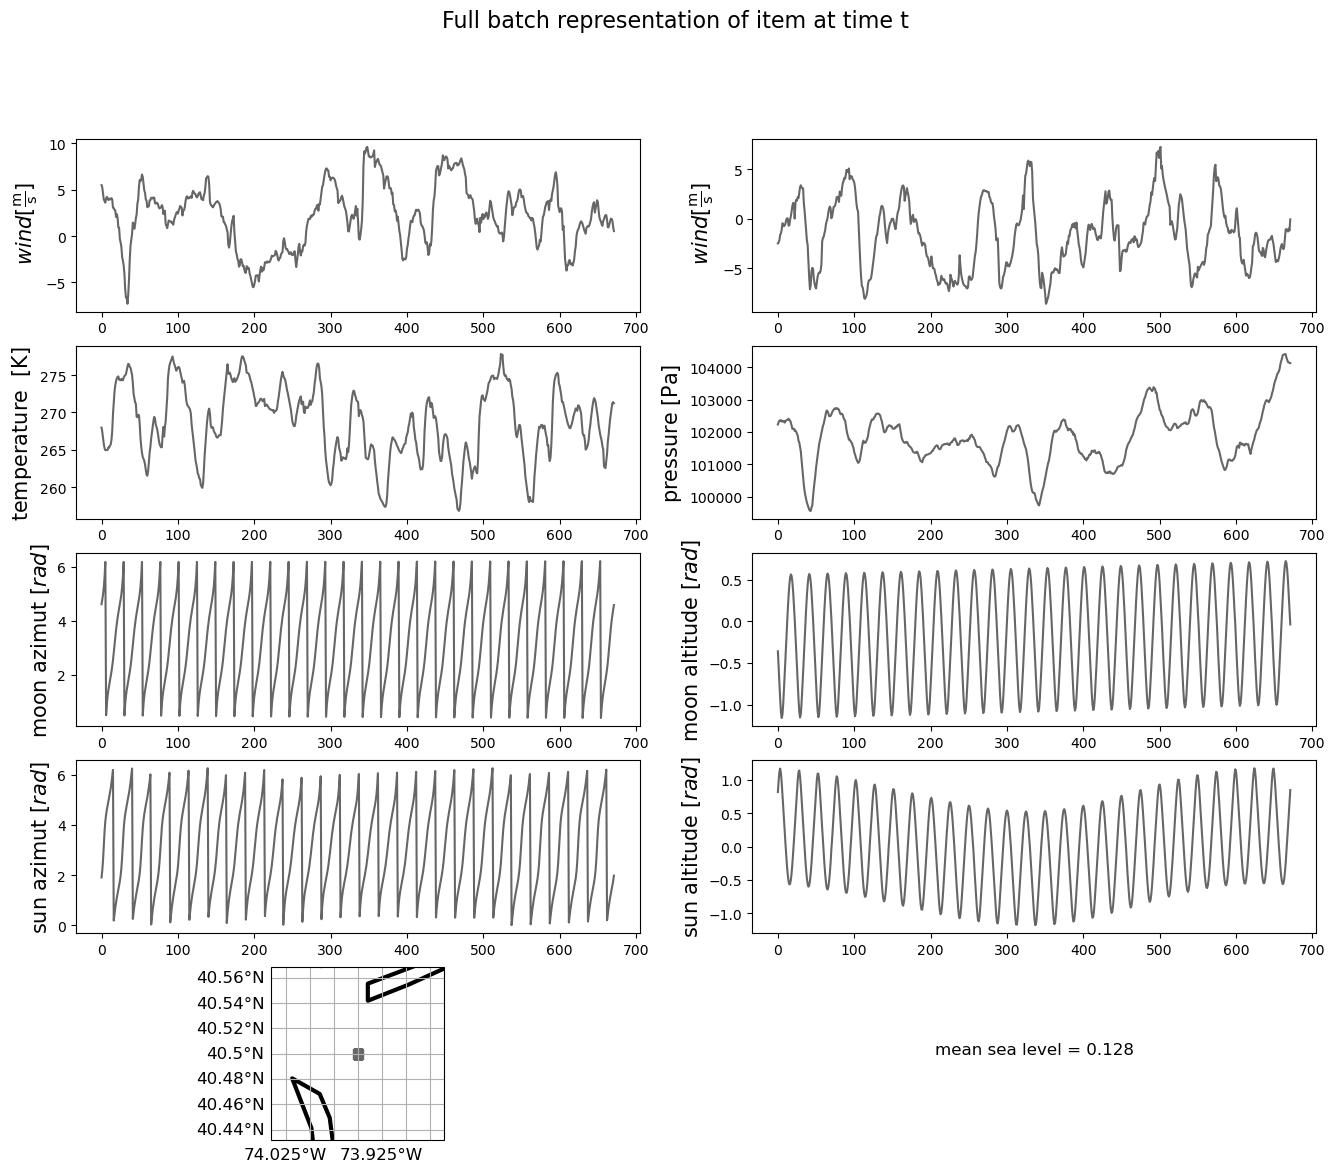

In [24]:
n_of_items = items[0].shape[0]-0
cf.generator_batch_plot(items[0],n_of_items,LSTM_recurrent_steps,palette_hex_list,ms_recurrent_steps,cmap_gen_plot)

In [25]:
from matplotlib.colors import to_rgba
# Creiamo la mappa dei colori combinata
palette_lat = palette_hex_list[0:5]
palette_lon = palette_hex_list[5:10]

def mix_colors(color1, color2):
    # Convert colors to RGBA
    rgba1 = np.array(to_rgba(color1))
    rgba2 = np.array(to_rgba(color2))
    # Mix colors
    mixed_rgba = (rgba1 + rgba2) / 2
    return mixed_rgba

def get_color(k, l):
    lat_color = palette_lat[k % len(palette_lat)]
    lon_color = palette_lon[l % len(palette_lon)]
    return mix_colors(lat_color, lon_color)

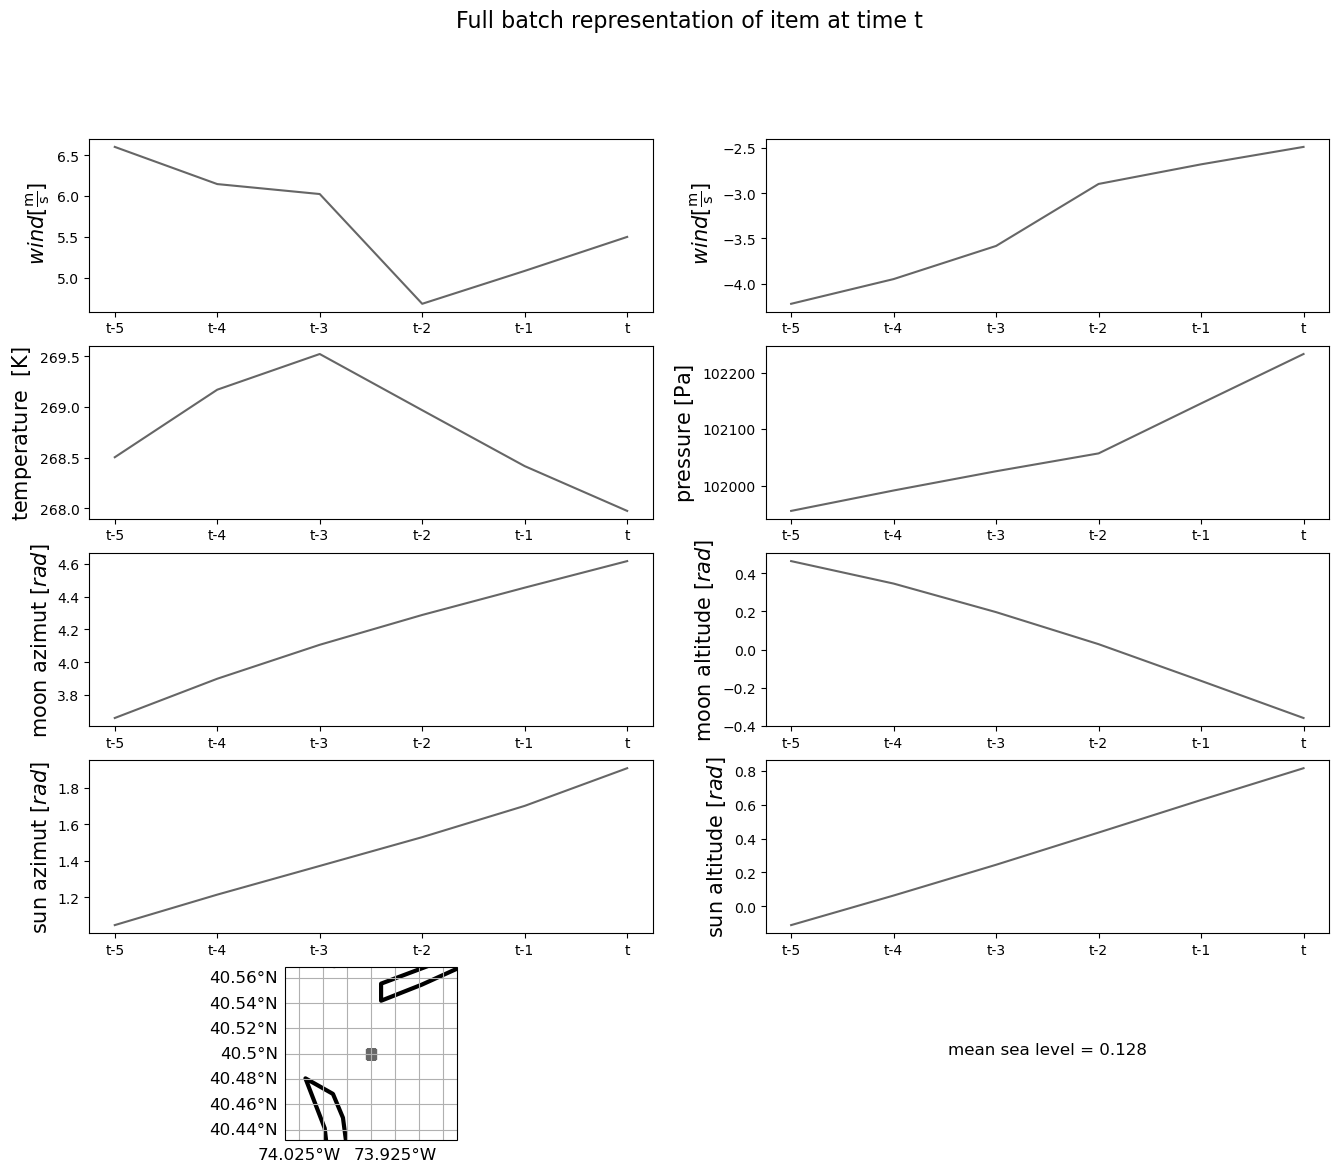

In [26]:
n_input = 0
cf.generator_oneinput_plot(items[0],n_input,LSTM_recurrent_steps,palette_hex_list,ms_recurrent_steps,cmap_gen_plot)

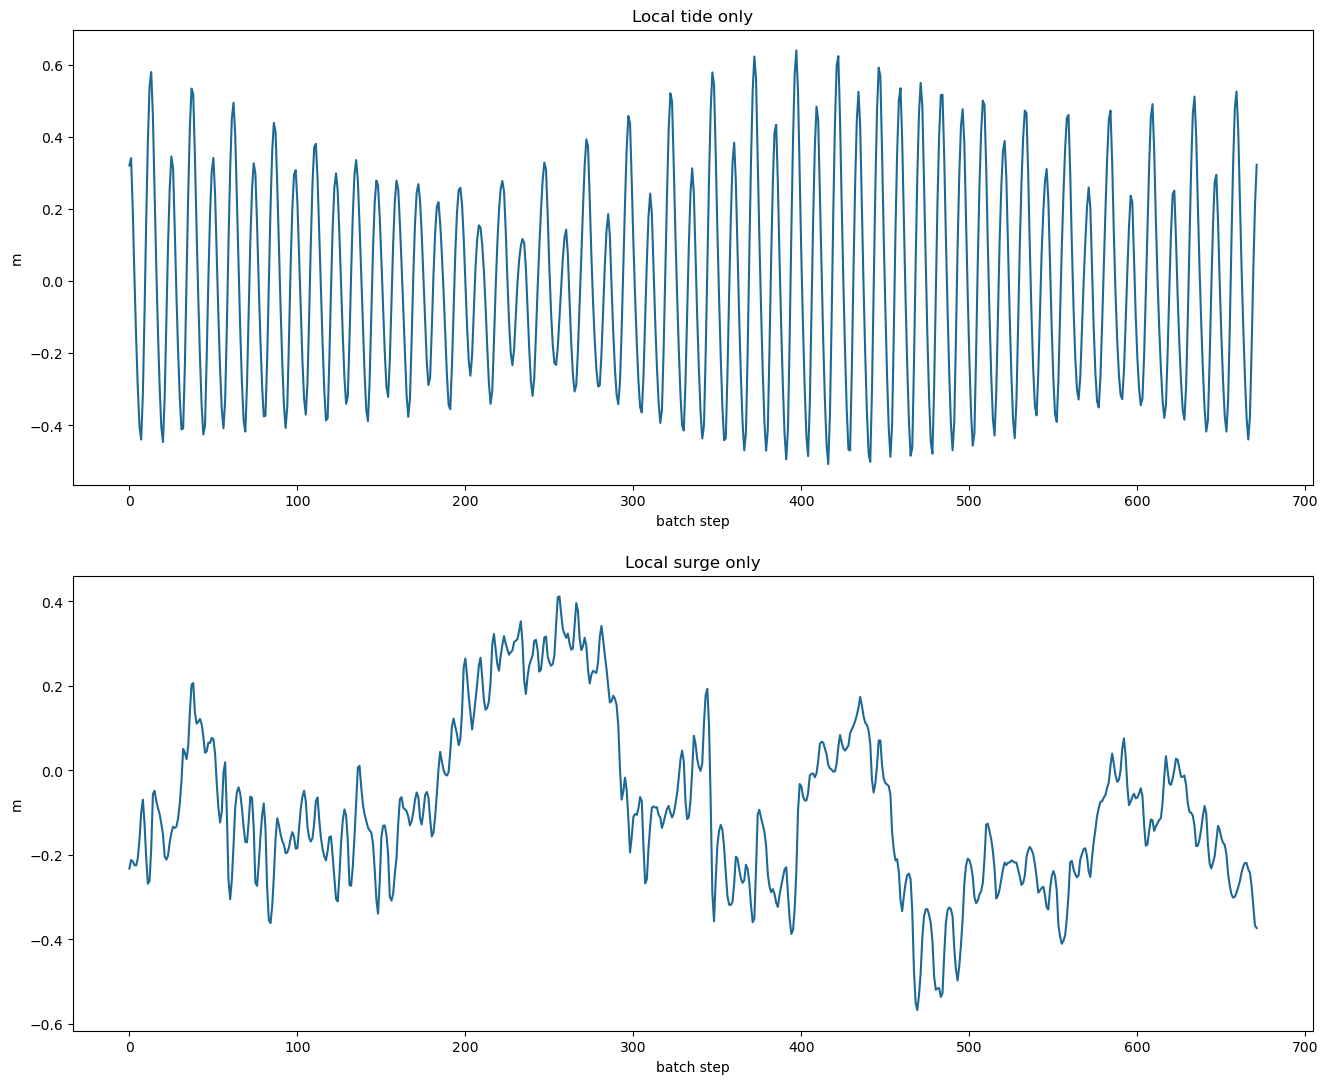

In [27]:
if output_type:
    output_batch = items[1][:,0]
    output_batch_2 = items[1][:,1]

    fig = plt.figure(figsize=(16, 13))
    #(1)
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(output_batch, label=f'Station {nearest_station_index}',color=palette_hex_list[1])
    ax.set_title('Local tide only')
    ax.set_xlabel('batch step')
    ax.set_ylabel("m")


    ax = fig.add_subplot(2, 1, 2)
    ax.plot(output_batch_2, label=f'Station {nearest_station_index}',color=palette_hex_list[1])
    ax.set_title('Local surge only')
    ax.set_xlabel('batch step')
    ax.set_ylabel("m")

    plt.show()

else:
    output_batch = items[1][:,0]

    plt.figure(figsize=(20, 4))
    plt.plot(output_batch, label=f'Station {nearest_station_index}',color=palette_hex_list[1])
    plt.title('Local waterlevel')
    plt.xlabel('batch step')
    plt.ylabel("m")
    plt.legend()
    plt.grid(True)
    plt.show()

#### Extract X,y and preprocess

In [28]:
X_name= output_path+'surrogate_GTSM_model/model_input_output/X_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(items[0].shape[1])+'_'+str(items[0].shape[2])+'_'+str(items[0].shape[3])+'.npy'
y_name= output_path+'surrogate_GTSM_model/model_input_output/y_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(items[1].shape[1])+'_.npy'

In [29]:
X_name

'/Users/eilab/Developed_Data/surrogate_GTSM_model/model_input_output/X_1979_2018_lat_40.701932_lon_-74.016228_shape_51_1_1.npy'

In [30]:
file_exists = os.path.isfile(X_name)
file_exists2 = os.path.isfile(y_name)

if (file_exists and file_exists2) ==False:
    # extract all
    gen = cgen.CustomDataGen(df, # pandas dataframe with paths
                            #  lat, lon, (-19.85, -19.85),(34.9, 34.9), # lat,lon min/max
                            # lat, lon, (-19, -20.5),(34.6, 36), # lat,lon min/max
                            lat, lon, (lat_bounds[0],lat_bounds[1]),(lon_bounds[0], lon_bounds[1]), # lat,lon min/max
                            nearest_station_index, # station index for GTSM dataset
                            train_y_bounds, # (y_start, y_stop)
                            train_month_start_end, # (m_start, m_stop)
                            train_files_shuffle, # shuffle datset at each epoch
                            LSTM_recurrent_steps, # recurrent steps for each input in LSTM
                            ms_recurrent_steps, # steps for az and alt input in LSTM
                            ["u10","v10","t2m","msl"], # variables in ERA5 datasets
                            len(df),# numer of df files to generate one training batch (i.e. number of months. see dir. structure)
                            False, # False or true for fill nan with rolling window (3 steps window)
                            True) # True  = type 2 (surge,tide_only) else (surge+tide)
    
    items = gen.__getitem__(0)

    np.save(X_name,items[0])
    if file_exists2==False:
        np.save(y_name,items[1])
    
    del items

X=np.load(X_name)
y=np.load(y_name)

In [31]:
# Fill NaN with rolling mean
print(np.argwhere(np.isnan(y))[:,0])
if sum(np.isnan(y))[0]>0:
    data_series = pd.Series(y[:,0])
    y[:,0] = data_series.fillna(data_series.rolling(window=3, min_periods=1).mean()).to_numpy()

    if output_type:
        data_series = pd.Series(y[:,1])
        y[:,1] = data_series.fillna(data_series.rolling(window=3, min_periods=1).mean()).to_numpy()
        
print(np.argwhere(np.isnan(y))[:,0])

[]
[]


In [32]:
if kfold == False:
    # Split Train, Val and test
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,  shuffle=False, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25,  shuffle=False, random_state=42)

    print(X_train.shape, y_train.shape)
    print(X_val.shape, y_val.shape)
    print(X_test.shape, y_test.shape)
    bbox_shape = X_train.shape[-2:]

In [33]:
if kfold == False:
    # Compute min and max
    if preprocess=="normalize":
        global_min, global_max = cfm.compute_min_max(X_train,y_train,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
        with open(local_data_path+'global_min_lat_'+str(lat)+'_lon_'+str(lon)+'.pkl', 'wb') as file:
            pickle.dump(global_min, file)
        with open(local_data_path+'global_max_lat_'+str(lat)+'_lon_'+str(lon)+'.pkl', 'wb') as file:
            pickle.dump(global_max, file)

    # Compute mean and iqr
    if preprocess=="robustscaling":
        global_mean, global_iqr = cfm.compute_mean_IQR(X_train,y_train,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
        with open(local_data_path+'global_mean_lat_'+str(lat)+'_lon_'+str(lon)+'.pkl', 'wb') as file:
            pickle.dump(global_mean, file)
        with open(local_data_path+'global_iqr_lat_'+str(lat)+'_lon_'+str(lon)+'.pkl', 'wb') as file:
            pickle.dump(global_iqr, file)

    # Compute mean and std
    if preprocess=="standardize":
        global_mean, global_std = cfm.compute_mean_std(X_train,y_train,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
        # correct if mean or std ==0
        if X_train.shape[3]==1 and X_train.shape[2]==1:
            global_std[9]  =1
            global_std[10] =1

        with open(local_data_path+'global_mean_lat_'+str(lat)+'_lon_'+str(lon)+'.pkl', 'wb') as file:
            pickle.dump(global_mean, file)
        with open(local_data_path+'global_std_lat_'+str(lat)+'_lon_'+str(lon)+'.pkl', 'wb') as file:
            pickle.dump(global_std, file)

In [34]:
if kfold == False:
    # normalize
    if preprocess=="normalize":
        X_train, y_train = cfm.normalize_min_max(X_train, y_train,global_min,global_max,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
        X_val, y_val = cfm.normalize_min_max(X_val, y_val,global_min,global_max,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
        X_test, y_test = cfm.normalize_min_max(X_test, y_test,global_min,global_max,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
        print("normalize")

    # robust scaling
    if preprocess=="robustscaling":
        X_train, y_train = cfm.robustscaling_mean_iqr(X_train, y_train,global_mean,global_iqr,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
        X_val, y_val = cfm.robustscaling_mean_iqr(X_val, y_val,global_mean,global_iqr,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
        X_test, y_test = cfm.robustscaling_mean_iqr(X_test, y_test,global_mean,global_iqr,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
        print("robustscaling")

    # standardize
    if preprocess=="standardize":
        X_train, y_train = cfm.standardize_mean_std(X_train, y_train,global_mean,global_std,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
        X_val, y_val = cfm.standardize_mean_std(X_val, y_val,global_mean,global_std,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
        X_test, y_test = cfm.standardize_mean_std(X_test, y_test,global_mean,global_std,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
        print("standardize")

In [35]:
if kfold == False: 
    y_train_name= output_path+'surrogate_GTSM_model/model_input_output/y_train_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_train.shape[1])+'_.npy'
    if (os.path.isfile(y_train_name)) ==False:
        np.save(y_train_name,y_train)
    y_val_name= output_path+'surrogate_GTSM_model/model_input_output/y_val_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_train.shape[1])+'_.npy'
    if (os.path.isfile(y_val_name)) ==False:
        np.save(y_val_name,y_val)
    y_test_name= output_path+'surrogate_GTSM_model/model_input_output/y_test_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_train.shape[1])+'_.npy'
    if (os.path.isfile(y_test_name)) ==False:
        np.save(y_test_name,y_test)

## Surrogate Neural Network model 

## __________________________________________________________________________________________________________


<font color=#ff69b4 style="font-size:20px; font-family:Arial;">Conv input shape</font> 
- If data_format="channels_last": A 4D tensor with shape: (batch_size, height, width, channels)
- If data_format="channels_first": A 4D tensor with shape: (batch_size, channels, height, width)(not supported)

<font color=#ff69b4 style="font-size:20px; font-family:Arial;">LSTM input shape</font> 
- inputs: A 3D tensor, with shape (batch, timesteps, feature)

<font color=#ff69b4 style="font-size:20px; font-family:Arial;">ConvLSTM input shape</font> 
- If data_format='channels_first': 5D tensor with shape: (samples, time, channels, rows, cols)(not supported)
- If data_format='channels_last': 5D tensor with shape: (samples, time, rows, cols, channels)
#### __________________________________________________________________________________________________________

In [36]:
if kfold == False:
    val_scores = []
    test_scores = []
    histories = []
    names = []
    colors = []

In [37]:
if kfold == False:
    if model_type =="conv":
        X_train = X_train.transpose(0, 2, 3, 1)
        X_val = X_val.transpose(0, 2, 3, 1)
        X_test = X_test.transpose(0, 2, 3, 1)

    if model_type =="lstm":
        X_train = cfm.reshape_for_lstm(X_train, LSTM_recurrent_steps)
        X_val = cfm.reshape_for_lstm(X_val, LSTM_recurrent_steps)
        X_test = cfm.reshape_for_lstm(X_test, LSTM_recurrent_steps)

    if model_type =="conv-lstm" or model_type =="conv3D" or model_type=="composite":
        X_train = cfm.reshape_for_convlstm(X_train, LSTM_recurrent_steps)
        X_val = cfm.reshape_for_convlstm(X_val, LSTM_recurrent_steps)
        X_test = cfm.reshape_for_convlstm(X_test, LSTM_recurrent_steps)


##### check reshape t-series

In [38]:
# # (samples, steps, covariates)
# if model_type =="conv-lstm":
#     fig = plt.figure(figsize=(16, 13))
    
#     for i in range(1,12):
#         ax = fig.add_subplot(6, 2, i)
#         if len(X_train.shape)==3:
#             ax.plot(X_train[0:300,-1,i-1].flatten(), label=f'Station {nearest_station_index}',color=palette_hex_list[1])
#             ax.plot(X_train[0:300,0,i-1].flatten(), label=f'Station {nearest_station_index}',color="r")
#         else:
#             ax.plot(X_train[0:300,-1,:,:,i-1].flatten(), label=f'Station {nearest_station_index}',color=palette_hex_list[1])
#             ax.plot(X_train[0:300,0,:,:,i-1].flatten(), label=f'Station {nearest_station_index}',color="r")

#         ax.set_title('Local tide only')
#         ax.set_xlabel('batch step')
#         ax.set_ylabel("m")

#     plt.show()

# # (samples, steps, lat, lon, var)
# if model_type =="lstm":
    
#     fig = plt.figure(figsize=(16, 13))

#     for i in range(1,12):
#         ax = fig.add_subplot(6, 2, i)
#         ax.plot(X_train[0:300,-1,i-1], label=f'Station {nearest_station_index}',color=palette_hex_list[1])
#         ax.plot(X_train[0:300,0,i-1], label=f'Station {nearest_station_index}',color="r")
#         ax.set_title('Local tide only')
#         ax.set_xlabel('batch step')
#         ax.set_ylabel("m")

#     plt.show()

In [39]:
if kfold == False:
    elastic_lambda=0.5e-6
    learning_rate=1e-3
    epochs = 20
    earl_patience=2

    if model_type =="dense":
        model = cfm.build_dense_model(X_train.shape[1:], y_train.shape[1:],learning_rate,elastic_lambda)

    if model_type =="conv":
        model = cfm.build_CONV_model(X_train.shape[1:], y_train.shape[1:],learning_rate,elastic_lambda,seed)

    if model_type =="lstm":
        model = cfm.build_LSTM_model(X_train.shape[1:], y_train.shape[1:],learning_rate,elastic_lambda,seed,"mse")

    if model_type =="conv-lstm":
        model = cfm.build_Conv_LSTM_model(X_train.shape[1:], y_train.shape[1:],learning_rate,elastic_lambda,seed)

    if model_type =="conv3D":
        model = cfm.build_Conv3D_model(X_train.shape[1:], y_train.shape[1:],learning_rate,elastic_lambda,seed)

    if model_type =="composite":
        model = cfm.build_composite_model(X_train.shape[1:], y_train.shape[1:],learning_rate,elastic_lambda,seed)
    
    model.summary()

In [40]:
if kfold == False:
    # new_learning_rate = 0.000085  
    # model.optimizer.learning_rate.assign(new_learning_rate)
    save_dir = output_path+"surrogate_GTSM_model/"+model_type+"_bbox"+str(bbox_shape[0])+str(bbox_shape[1])+"_"+preprocess+"_model_"+str(X_train.shape[1:])
    model_name = save_dir+"/"+model_type+'_Model.keras'
    epochs = 3
    if os.path.isfile(model_name)==False:
        # Train the model 
        history = model.fit(
            x = X_train.astype(np.float32),
            y = y_train.astype(np.float32), 
            validation_data=(X_val.astype(np.float32), y_val.astype(np.float32)),
            batch_size = 20000, 
            epochs = epochs,
            shuffle=True,
            callbacks = [
                tfk.callbacks.EarlyStopping(monitor='val_mse', mode='min', patience=earl_patience, restore_best_weights=True),
                tfk.callbacks.ReduceLROnPlateau(monitor='val_mse', mode='min', patience=1, factor=0.1, min_lr=1e-5)
            ]
        ).history

In [41]:
# create indicies
if True:
    # timestamps = pd.date_range(start=str(train_y_bounds[0])+'-'+f"{train_month_start_end[0]:02}"+'-01', end=str(train_y_bounds[1])+'-'+f"{train_month_start_end[1]:02}"+'-31', freq='h').to_numpy()
    # timestamps = timestamps[(LSTM_recurrent_steps-1):]
    #_______________________________________________________________________________________
    def generate_hourly_dates(start_year, start_month, end_year, end_month):
        # Genera una data di inizio e una data di fine
        start_date = pd.Timestamp(year=start_year, month=start_month, day=1, hour=0, minute=0)
        # Calcola l'ultimo giorno del mese di fine
        end_date = pd.Timestamp(year=end_year, month=end_month, day=1, hour=0, minute=0) + pd.offsets.MonthEnd(0) + pd.DateOffset(hour=23, minute=59)
        
        # Genera il vettore di date con passo orario
        date_range = pd.date_range(start=start_date, end=end_date, freq='h')
        return date_range

    # Generazione del vettore di date
    start_year = train_y_bounds[0]
    start_month = train_month_start_end[0]
    end_year = train_y_bounds[1]
    end_month = train_month_start_end[1]
    dates = generate_hourly_dates(start_year, start_month, end_year, end_month)
    # Supponiamo di avere il tuo DatetimeIndex chiamato `timestamps`
    timestamps = dates.to_numpy().astype('datetime64[ns]')
    #_______________________________________________________________________________________
    yarstamps = pd.date_range(start=str(train_y_bounds[0]), end=str(train_y_bounds[1]), freq='YE').to_numpy()
    # Estrai gli anni dai timestamp
    print(len(timestamps))
    years = timestamps.astype('datetime64[Y]').astype(int)+1970
    # Definisci gli anni di train e test
    train_val_years, test_years = train_test_split( np.unique(years), test_size=0.12, shuffle=True, random_state=50)

349896


In [42]:
test_years

array([2010, 1980, 2015, 1995, 2006])

In [ ]:
# create indicies
if False:
    # timestamps = pd.date_range(start=str(train_y_bounds[0])+'-'+f"{train_month_start_end[0]:02}"+'-01', end=str(train_y_bounds[1])+'-'+f"{train_month_start_end[1]:02}"+'-31', freq='h').to_numpy()
    # timestamps = timestamps[(LSTM_recurrent_steps-1):]
    #_______________________________________________________________________________________
    def generate_hourly_dates(start_year, start_month, end_year, end_month):
        # Genera una data di inizio e una data di fine
        start_date = pd.Timestamp(year=start_year, month=start_month, day=1, hour=0, minute=0)
        # Calcola l'ultimo giorno del mese di fine
        end_date = pd.Timestamp(year=end_year, month=end_month, day=1, hour=0, minute=0) + pd.offsets.MonthEnd(0) + pd.DateOffset(hour=23, minute=59)
        
        # Genera il vettore di date con passo orario
        date_range = pd.date_range(start=start_date, end=end_date, freq='h')
        return date_range

    # Generazione del vettore di date
    start_year = train_y_bounds[0]
    start_month = train_month_start_end[0]
    end_year = train_y_bounds[1]
    end_month = train_month_start_end[1]
    dates = generate_hourly_dates(start_year, start_month, end_year, end_month)
    # Supponiamo di avere il tuo DatetimeIndex chiamato `timestamps`
    timestamps = dates.to_numpy().astype('datetime64[ns]')
    #_______________________________________________________________________________________
    yarstamps = pd.date_range(start=str(train_y_bounds[0]), end=str(train_y_bounds[1]), freq='YE').to_numpy()
    # Estrai gli anni dai timestamp
    print(len(timestamps))
    years = timestamps.astype('datetime64[Y]').astype(int)+1970
    # Definisci gli anni di train e test
    train_val_years, test_years = train_test_split( np.unique(years), test_size=0.12, shuffle=True, random_state=50)
    print("test years: "+str(test_years))
    # Ottieni gli indici dei campioni per ogni set
    test_indices = np.where(np.isin(years, test_years))[0]
    train_val_indices = np.where(np.isin(years, train_val_years))[0]

    arrays_train_indicies = {}
    arrays_val_indicies = {}

    kf = KFold(n_splits=folds_number, shuffle=True, random_state=seed)

    k=0
    for train_fold_index, val_fold_index in kf.split(train_val_years):
        k = k+1
        print("fold: "+str(k))
        train_years = train_val_years[train_fold_index,...]
        val_years = train_val_years[val_fold_index,...]
        print("train years: "+str(train_years))
        print("val years: "+str(val_years))

        train_indices = np.where(np.isin(years, train_years))[0]
        train_array_name = f'train_indices_fold_{k}'
        arrays_train_indicies[train_array_name] = np.ones(len(train_indices))
        arrays_train_indicies[train_array_name][:] = train_indices

        val_indices = np.where(np.isin(years, val_years))[0]
        val_array_name = f'val_indices_fold_{k}'
        arrays_val_indicies[val_array_name] = np.ones(len(val_indices))
        arrays_val_indicies[val_array_name] = val_indices 


        X_test = X[test_indices,...]
        print(X_test.shape)
        X_train = X[arrays_train_indicies[train_array_name].astype(int),...]
        print(X_train.shape)
        X_val = X[arrays_val_indicies[val_array_name].astype(int),...]
        print(X_val.shape)
        print("tot: "+str(X_val.shape[0]+X_train.shape[0]+X_test.shape[0]))

    # save
    np.save(local_data_path+'train_val_indices.npy', train_val_indices)
    np.save(local_data_path+'test_indices.npy', test_indices)
    np.save(local_data_path+'arrays_train_indicies.npy', arrays_train_indicies, allow_pickle=True)
    np.save(local_data_path+'arrays_val_indicies.npy', arrays_val_indicies, allow_pickle=True)

kfold_global_mean = [[],[],[],[],[]]
kfold_global_std = [[],[],[],[],[]]

if kfold:
    seed=42
    # fold
    # _________________________LOAD_INDICIES_____________________________________________________
    # load
    train_val_indices = np.load(local_data_path+'train_val_indices.npy')
    test_indices = np.load(local_data_path+'test_indices.npy')
    arrays_train_indicies = np.load(local_data_path+'arrays_train_indicies.npy', allow_pickle=True).item()
    arrays_val_indicies = np.load(local_data_path+'arrays_val_indicies.npy', allow_pickle=True).item()
    k = 0
    # _________________________LOOP______________________________________________________________
    for fold in range(folds_number):
        k = k+1
        # Usa gli indici generati da KFold per creare i set di training e validation
        X_train_val, X_test, y_train_val, y_test = X[train_val_indices,...], X[test_indices,...], y[train_val_indices,...], y[test_indices,...]
        train_array_name = f'train_indices_fold_{k}'
        val_array_name = f'val_indices_fold_{k}'
        X_train, X_val = X[arrays_train_indicies[train_array_name].astype(int),...], X[arrays_val_indicies[val_array_name].astype(int),...]
        y_train, y_val = y[arrays_train_indicies[train_array_name].astype(int),...], y[arrays_val_indicies[val_array_name].astype(int),...]
        print(f"Fold {fold+1}")
        print(X_train.shape, y_train.shape)
        print(X_val.shape, y_val.shape)
        print(X_test.shape, y_test.shape)
        bbox_shape = X_train.shape[-2:]
    #_________________________PREPROCESS_FOLD____________________________________________________
        # Compute min and max
        if preprocess=="normalize":
            global_min, global_max = cfm.compute_min_max(X_train,y_train,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
        # Compute mean and iqr
        if preprocess=="robustscaling":
            global_mean, global_iqr = cfm.compute_mean_IQR(X_train,y_train,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
        # Compute mean and std
        if preprocess=="standardize":
            global_mean, global_std = cfm.compute_mean_std(X_train,y_train,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
            kfold_global_mean[fold].append(global_mean)
            kfold_global_std[fold].append(global_std)

if preprocess=="standardize":
    with open(local_data_path+'kfold_global_mean_lat_'+str(lat)+'_lon_'+str(lon)+'.pkl', 'wb') as file:
        pickle.dump(kfold_global_mean, file)
    with open(local_data_path+'kfold_global_std_lat_'+str(lat)+'_lon_'+str(lon)+'.pkl', 'wb') as file:
        pickle.dump(kfold_global_std, file)


Fold 1
(244728, 51, 6, 6) (244728, 2)
(61344, 51, 6, 6) (61344, 2)
(43824, 51, 6, 6) (43824, 2)
Fold 2
(244704, 51, 6, 6) (244704, 2)
(61368, 51, 6, 6) (61368, 2)
(43824, 51, 6, 6) (43824, 2)
Fold 3
(245424, 51, 6, 6) (245424, 2)
(60648, 51, 6, 6) (60648, 2)
(43824, 51, 6, 6) (43824, 2)
Fold 4
(244752, 51, 6, 6) (244752, 2)
(61320, 51, 6, 6) (61320, 2)
(43824, 51, 6, 6) (43824, 2)
Fold 5
(244680, 51, 6, 6) (244680, 2)
(61392, 51, 6, 6) (61392, 2)
(43824, 51, 6, 6) (43824, 2)


In [48]:
# models_types = ["dense","conv","con3D","lstm","conv-lstm"]
models_types = ["lstm"]
if kfold:
    for mod in range(len(models_types)):
        model_type = models_types[mod]
        seed=42
        # fold
        # _________________________LOAD_INDICIES_____________________________________________________
        # load
        train_val_indices = np.load(local_data_path+'train_val_indices.npy')
        test_indices = np.load(local_data_path+'test_indices.npy')
        arrays_train_indicies = np.load(local_data_path+'arrays_train_indicies.npy', allow_pickle=True).item()
        arrays_val_indicies = np.load(local_data_path+'arrays_val_indicies.npy', allow_pickle=True).item()
        k = 0
        # _________________________LOOP______________________________________________________________
        for fold in range(folds_number):
            k = k+1
            # Usa gli indici generati da KFold per creare i set di training e validation
            X_train_val, X_test, y_train_val, y_test = X[train_val_indices,...], X[test_indices,...], y[train_val_indices,...], y[test_indices,...]
            train_array_name = f'train_indices_fold_{k}'
            val_array_name = f'val_indices_fold_{k}'
            X_train, X_val = X[arrays_train_indicies[train_array_name].astype(int),...], X[arrays_val_indicies[val_array_name].astype(int),...]
            y_train, y_val = y[arrays_train_indicies[train_array_name].astype(int),...], y[arrays_val_indicies[val_array_name].astype(int),...]
            print(f"Fold {fold+1}")
            print(X_train.shape, y_train.shape)
            print(X_val.shape, y_val.shape)
            print(X_test.shape, y_test.shape)
            bbox_shape = X_train.shape[-2:]
        #_________________________PREPROCESS_FOLD____________________________________________________
            # Compute min and max
            if preprocess=="normalize":
                global_min, global_max = cfm.compute_min_max(X_train,y_train,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
            # Compute mean and iqr
            if preprocess=="robustscaling":
                global_mean, global_iqr = cfm.compute_mean_IQR(X_train,y_train,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
            # Compute mean and std
            if preprocess=="standardize":
                global_mean, global_std = cfm.compute_mean_std(X_train,y_train,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
            # normalize
            if preprocess=="normalize":
                X_train, y_train = cfm.normalize_min_max(X_train, y_train,global_min,global_max,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
                X_val, y_val = cfm.normalize_min_max(X_val, y_val,global_min,global_max,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
                X_test, y_test = cfm.normalize_min_max(X_test, y_test,global_min,global_max,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
                print("normalize")
            # robust scaling
            if preprocess=="robustscaling":
                X_train, y_train = cfm.robustscaling_mean_iqr(X_train, y_train,global_mean,global_iqr,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
                X_val, y_val = cfm.robustscaling_mean_iqr(X_val, y_val,global_mean,global_iqr,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
                X_test, y_test = cfm.robustscaling_mean_iqr(X_test, y_test,global_mean,global_iqr,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
                print("robustscaling")
            # standardize
            if preprocess=="standardize":
                X_train, y_train = cfm.standardize_mean_std(X_train, y_train,global_mean,global_std,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
                X_val, y_val = cfm.standardize_mean_std(X_val, y_val,global_mean,global_std,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
                X_test, y_test = cfm.standardize_mean_std(X_test, y_test,global_mean,global_std,LSTM_recurrent_steps,ms_recurrent_steps,output_type)
                print("standardize")
            y_train_name= output_path+'surrogate_GTSM_model/model_input_output/y_train_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_train.shape[1])+'_.npy'
            if (os.path.isfile(y_train_name)) ==False:
                np.save(y_train_name,y_train)
            y_val_name= output_path+'surrogate_GTSM_model/model_input_output/y_val_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_train.shape[1])+'_.npy'
            if (os.path.isfile(y_val_name)) ==False:
                np.save(y_val_name,y_val)
            y_test_name= output_path+'surrogate_GTSM_model/model_input_output/y_test_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_train.shape[1])+'_.npy'
            if (os.path.isfile(y_test_name)) ==False:
                np.save(y_test_name,y_test)
            if model_type =="conv":
                X_train = X_train.transpose(0, 2, 3, 1)
                X_val = X_val.transpose(0, 2, 3, 1)
                X_test = X_test.transpose(0, 2, 3, 1)
            if model_type =="lstm":
                X_train = cfm.reshape_for_lstm(X_train, LSTM_recurrent_steps)
                X_val = cfm.reshape_for_lstm(X_val, LSTM_recurrent_steps)
                X_test = cfm.reshape_for_lstm(X_test, LSTM_recurrent_steps)
            if model_type =="conv-lstm" or model_type =="conv3D" or model_type=="composite":
                X_train = cfm.reshape_for_convlstm(X_train, LSTM_recurrent_steps)
                X_val = cfm.reshape_for_convlstm(X_val, LSTM_recurrent_steps)
                X_test = cfm.reshape_for_convlstm(X_test, LSTM_recurrent_steps)
        #_________________________TRAIN____________________________________________________
            elastic_lambda=0.5e-6
            learning_rate=1e-3
            epochs = 25
            earl_patience=2
            if model_type =="dense":
                model = cfm.build_dense_model(X_train.shape[1:], y_train.shape[1:],learning_rate,elastic_lambda,loss_type)
            if model_type =="conv":
                model = cfm.build_CONV_model(X_train.shape[1:], y_train.shape[1:],learning_rate,elastic_lambda,seed,loss_type)
            if model_type =="lstm":
                model = cfm.build_LSTM_model(X_train.shape[1:], y_train.shape[1:],learning_rate,elastic_lambda,seed,loss_type)
            if model_type =="conv-lstm":
                model = cfm.build_Conv_LSTM_model(X_train.shape[1:], y_train.shape[1:],learning_rate,elastic_lambda,seed,loss_type)
            if model_type =="conv3D":
                model = cfm.build_Conv3D_model(X_train.shape[1:], y_train.shape[1:],learning_rate,elastic_lambda,seed,loss_type)
            model.summary()
            print(model.loss)
            save_dir = output_path+"surrogate_GTSM_model/models/"+model_type+"_"+str(folds_number)+"folds_bbox"+str(bbox_shape[0])+str(bbox_shape[1])+"_steps"+str(LSTM_recurrent_steps)+"_loss_"+loss_type+"_"+preprocess+"_model"
            model_name = save_dir+"/"+model_type+'_k'+str(fold)+'_Model.keras'
            history_path = os.path.join(save_dir, 'history_k'+str(fold)+'.pkl')
            # if os.path.isfile(model_name)==False:
            #     # Train the model 
            #     history = model.fit(
            #         x = X_train,
            #         y = y_train, 
            #         validation_data=(X_val, y_val),
            #         batch_size = 6500,
            #         epochs = epochs,verbose=2,
            #         shuffle=True,
            #         callbacks = [
            #             tfk.callbacks.EarlyStopping(monitor='val_mse', mode='min', patience=earl_patience, restore_best_weights=True),
            #             tfk.callbacks.ReduceLROnPlateau(monitor='val_mse', mode='min', patience=1, factor=0.1, min_lr=1e-7)
            #         ]
            #     ).history
    # #_________________________SAVE____________________________________________________
    #         # save model and history
    #         if not os.path.exists(save_dir):
    #             os.makedirs(save_dir)
    #         if os.path.isfile(model_name)==False:
    #             model.save(model_name)
    #         if os.path.isfile(history_path)==False:
    #             with open(history_path, 'wb') as f:
    #                 pickle.dump(history, f)
    #         # Inference
    #         y_predict = model.predict(X_train)
    #         y_predict = y_predict[:,:]
    #         print(y_predict.shape)
    #         y_name = save_dir+"/y_train_k"+str(fold)+"_predict.npy"
    #         np.save(y_name,y_predict)
    #         model.evaluate(x=X_train,
    #                         y=y_train,
    #                         verbose=2,
    #                         batch_size=6500)
    #         print(mean_squared_error(y_train, y_predict))


    #         y_val_predict = model.predict(X_val)
    #         y_val_predict = y_val_predict[:,:]
    #         print(y_val_predict.shape)
    #         y_name = save_dir+"/y_val_k"+str(fold)+"_predict.npy"
    #         np.save(y_name,y_val_predict)
    #         model.evaluate(x=X_val,
    #                         y=y_val,
    #                         verbose=2,
    #                         batch_size=6500)
    #         print(mean_squared_error(y_val, y_val_predict))

    #         y_test_predict = model.predict(X_test)
    #         y_test_predict = y_test_predict[:,:]
    #         print(y_test_predict.shape)
    #         y_name = save_dir+"/y_test_k"+str(fold)+"_predict.npy"
    #         np.save(y_name,y_test_predict)
    #         model.evaluate(x=X_test,
    #                         y=y_test,
    #                         verbose=2,
    #                         batch_size=6500)
    #         print(mean_squared_error(y_test, y_test_predict))


Fold 1
(244728, 1923, 1, 1) (244728, 2)
(61344, 1923, 1, 1) (61344, 2)
(43824, 1923, 1, 1) (43824, 2)
standardize


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 11)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 240, 128)       │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 240, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 240, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classifier (Dense)              │ (None, 32)             │       245,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 379,362 (1.45 MB)

 Trainable params: 379,362 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

Fold 2
(244704, 1923, 1, 1) (244704, 2)
(61368, 1923, 1, 1) (61368, 2)
(43824, 1923, 1, 1) (43824, 2)
standardize


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 11)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 240, 128)       │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 240, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 240, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classifier (Dense)              │ (None, 32)             │       245,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 379,362 (1.45 MB)

 Trainable params: 379,362 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

Fold 3
(245424, 1923, 1, 1) (245424, 2)
(60648, 1923, 1, 1) (60648, 2)
(43824, 1923, 1, 1) (43824, 2)
standardize


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 11)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 240, 128)       │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 240, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 240, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classifier (Dense)              │ (None, 32)             │       245,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 379,362 (1.45 MB)

 Trainable params: 379,362 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

Fold 4
(244752, 1923, 1, 1) (244752, 2)
(61320, 1923, 1, 1) (61320, 2)
(43824, 1923, 1, 1) (43824, 2)
standardize


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 11)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 240, 128)       │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 240, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 240, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classifier (Dense)              │ (None, 32)             │       245,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 379,362 (1.45 MB)

 Trainable params: 379,362 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

Fold 5
(244680, 1923, 1, 1) (244680, 2)
(61392, 1923, 1, 1) (61392, 2)
(43824, 1923, 1, 1) (43824, 2)
standardize


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 11)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 240, 128)       │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 240, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 240, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classifier (Dense)              │ (None, 32)             │       245,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 379,362 (1.45 MB)

 Trainable params: 379,362 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
if kfold == False:
    # save model and history
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    model_name = save_dir+"/"+model_type+'_Model.keras'
    if os.path.isfile(model_name)==False:
        model.save(model_name)

    if os.path.isfile(model_name)==True:
        model = tfk.models.load_model(model_name)

    history_path = os.path.join(save_dir, 'history.pkl')
    if os.path.isfile(history_path)==False:
        with open(history_path, 'wb') as f:
            pickle.dump(history, f)

    if os.path.isfile(history_path)==True:
        with open(history_path, 'rb') as f:
            history = pickle.load(f)

In [ ]:
if kfold == False:
    # Inference
    y_predict = model.predict(X_train)
    y_predict = y_predict[:,:]
    print(y_predict.shape)
    y_name = save_dir+"/y_train_predict.npy"
    np.save(y_name,y_predict)

    y_val_predict = model.predict(X_val)
    y_val_predict = y_val_predict[:,:]
    print(y_val_predict.shape)
    y_name = save_dir+"/y_val_predict.npy"
    np.save(y_name,y_val_predict)

    y_test_predict = model.predict(X_test)
    y_test_predict = y_test_predict[:,:]
    print(y_test_predict.shape)
    y_name = save_dir+"/y_test_predict.npy"
    np.save(y_name,y_test_predict)

In [ ]:
if kfold == False:
   # Store results
    if len(history["mse"]) == epochs:
        print('Train MSE %.9f' % history["mse"][-1])
    else:
        print('Train MSE %.9f' % history["mse"][-(earl_patience+1)])

    val_scores.append(mean_squared_error(y_val, y_val_predict))
    print('Validation MSE %.9f' % val_scores[0])
    test_scores.append(mean_squared_error(y_test, y_test_predict))
    print('Test MSE %.9f' % test_scores[0])
    histories.append(history)
    names.append('FC Model')
    colors.append(palette_hex_list[7])

In [ ]:
if kfold == False:
    cfm.monitor(histories, names, colors, 1)

In [ ]:
if kfold == False:
    # Plot 
    if output_type:
        fig = plt.figure(figsize=(16, 13))
        #(1)
        ax = fig.add_subplot(3, 1, 1)
        ax.plot(y_train[:1000,0],c=palette_hex_list[0],lw=4, label='GTSM v3.0')
        ax.plot(y_predict[:1000,0],c=palette_hex_list[7], label='Model Output')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel("tide only", fontsize=12)
        ax.legend()


        #(2)
        ax = fig.add_subplot(3, 1, 2)
        ax.plot(y_train[:1000,1],c=palette_hex_list[0],lw=4, label='GTSM v3.0')
        ax.plot(y_predict[:1000,1],c=palette_hex_list[7], label='Model Output')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel("surge", fontsize=12)
        ax.legend()


        #(3)
        if preprocess == "normalize":
            ax = fig.add_subplot(3, 1, 3)
            ax.plot(y_train[:1000,0]*(global_max[-2]-global_min[-2])+(global_min[-2])+y_train[:1000,1]*(global_max[-1]-global_min[-1])+(global_min[-1]),c=palette_hex_list[0],lw=4, label='GTSM v3.0')
            ax.plot(y_predict[:1000,0]*(global_max[-2]-global_min[-2])+(global_min[-2])+y_predict[:1000,1]*(global_max[-1]-global_min[-1])+(global_min[-1]),c=palette_hex_list[7], label='Model Output')
            ax.set_xlabel('Sample Index')
            ax.set_ylabel("waterlevel", fontsize=12)
            ax.legend()
        if preprocess == "standardize":
            ax = fig.add_subplot(3, 1, 3)
            ax.plot(y_train[:1000,0]*(global_std[-2])+(global_mean[-2])+y_train[:1000,1]*(global_std[-1])+(global_mean[-1]),c=palette_hex_list[0],lw=4, label='GTSM v3.0')
            ax.plot(y_predict[:1000,0]*(global_std[-2])+(global_mean[-2])+y_predict[:1000,1]*(global_std[-1])+(global_mean[-1]),c=palette_hex_list[7], label='Model Output')
            ax.set_xlabel('Sample Index')
            ax.set_ylabel("waterlevel", fontsize=12)
            ax.legend()   
        if preprocess == "robustscaling":
            ax = fig.add_subplot(3, 1, 3)
            ax.plot(y_train[:1000,0]*(global_iqr[-2])+(global_mean[-2])+y_train[:1000,1]*(global_iqr[-1])+(global_mean[-1]),c=palette_hex_list[0],lw=4, label='GTSM v3.0')
            ax.plot(y_predict[:1000,0]*(global_iqr[-2])+(global_mean[-2])+y_predict[:1000,1]*(global_iqr[-1])+(global_mean[-1]),c=palette_hex_list[7], label='Model Output')
            ax.set_xlabel('Sample Index')
            ax.set_ylabel("waterlevel", fontsize=12)
            ax.legend()   
        plt.suptitle('Observations vs Model Output')
        plt.show()



    else:
        plt.figure(figsize=(10, 6))
        plt.plot(y_train[:1000,:],c=palette_hex_list[0],lw=4, label='GTSM v3.0')
        plt.plot(y_predict[:1000,:],c=palette_hex_list[7], label='Model Output')
        plt.xlabel('Sample Index')
        plt.ylabel('Value')
        plt.title('Observations vs Model Output')
        plt.legend()
        plt.show()